In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import seaborn as sns

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/', 
                                              target_size=(256, 256), 
                                              batch_size=32, 
                                              class_mode='categorical')
test_set = test_datagen.flow_from_directory('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/', 
                                            target_size=(256, 256), 
                                            batch_size=32, 
                                            class_mode='categorical',
                                            shuffle=False)

Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
train_path='/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/'
No_images_per_class = []
Class_name = []
for i in os.listdir(train_path):
  train_class = os.listdir(os.path.join(train_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No Impairment = 2560 

Number of images in Very Mild Impairment = 2560 

Number of images in Moderate Impairment = 2560 

Number of images in Mild Impairment = 2560 



In [5]:
test_path='/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/'
No_images_per_class = []
Class_name = []
for i in os.listdir(test_path):
  train_class = os.listdir(os.path.join(test_path, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in No Impairment = 640 

Number of images in Very Mild Impairment = 448 

Number of images in Moderate Impairment = 12 

Number of images in Mild Impairment = 179 



In [6]:
from glob import glob
# useful for getting number of output classes
folders = glob('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/*')
print(len(folders))

4


In [7]:
from tensorflow.keras.layers import Layer

# Define the spatial attention mechanism
class SpatialAttention(Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def build(self, input_shape):
        # Create a trainable convolutional layer for spatial attention
        self.conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        # Calculate channel-wise mean
        channel_mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        
        # Apply the spatial attention mechanism
        spatial_attention_map = self.conv(channel_mean)
        
        # Multiply the input feature maps by the spatial attention map
        attended_feature_maps = x * spatial_attention_map
        
        return attended_feature_maps


In [7]:
# Define the channel attention mechanism
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.global_avg_pooling = GlobalAveragePooling2D()
        self.dense_1 = Dense(units=input_shape[-1] // 2, activation='relu')
        self.dense_2 = Dense(units=input_shape[-1], activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, x):
        avg_pool = self.global_avg_pooling(x)
        avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
        avg_pool = self.dense_1(avg_pool)
        avg_pool = self.dense_2(avg_pool)
        return Multiply()([x, avg_pool])

In [8]:
# Create a Sequential model
model = Sequential()

# Add Conv2D layers followed by channel attention mechanisms
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(ChannelAttention())  # First channel attention
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ChannelAttention())  # Second channel attention
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(folders), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 channel_attention (ChannelA  (None, 254, 254, 32)     1072      
 ttention)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 channel_attention_1 (Channe  (None, 125, 125, 64)     4192      
 lAttention)                                                     
                                                        

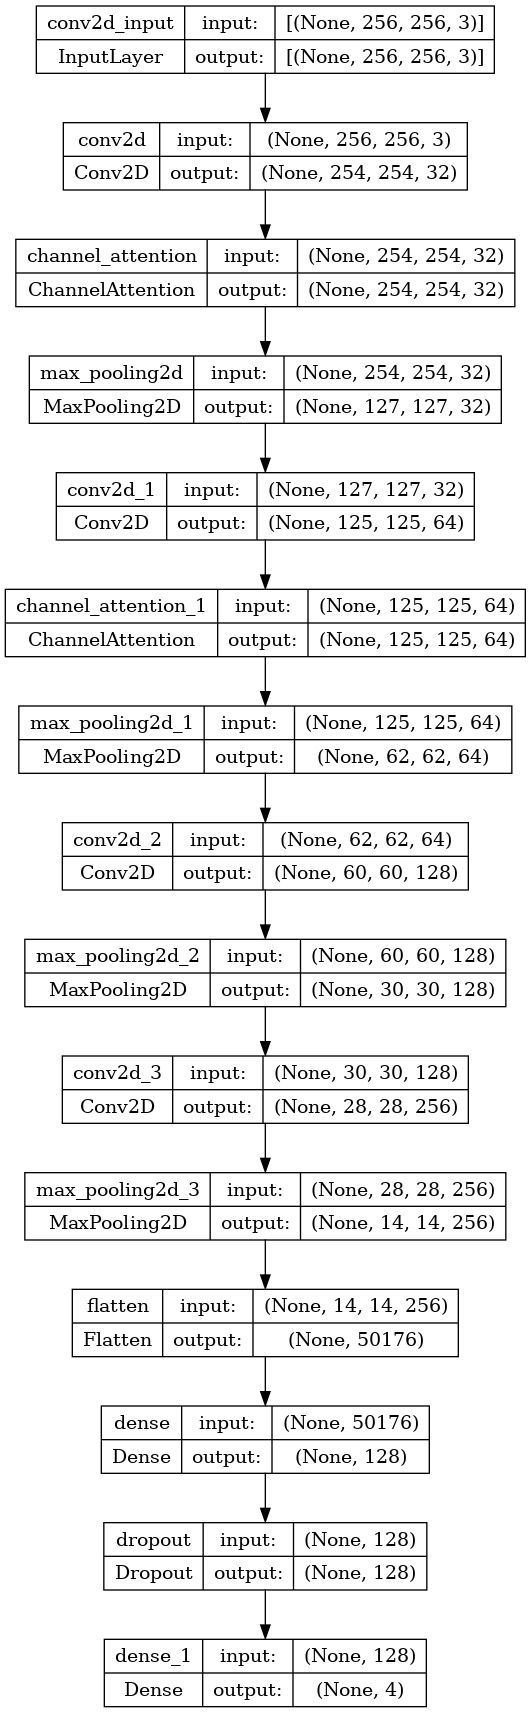

In [9]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
filepath1="best_weights.h5"
filepath2="best_model.json"
checkpoint = ModelCheckpoint(filepath1, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             mode='max')
callbacks_list = [checkpoint]

In [11]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.samples//32,
                    epochs=100,
                    validation_data=test_set,
                    validation_steps=test_set.samples//32,
                    callbacks=callbacks_list)

Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 1.3029 - accuracy: 0.3381
Epoch 1: val_accuracy improved from -inf to 0.44391, saving model to best_weights.h5
320/320 [==============================] - 272s 803ms/step - loss: 1.3029 - accuracy: 0.3381 - val_loss: 1.0655 - val_accuracy: 0.4439
Epoch 2/100
320/320 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.6146
Epoch 2: val_accuracy improved from 0.44391 to 0.51362, saving model to best_weights.h5
320/320 [==============================] - 214s 668ms/step - loss: 0.8229 - accuracy: 0.6146 - val_loss: 0.8771 - val_accuracy: 0.5136
Epoch 3/100
320/320 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.6875
Epoch 3: val_accuracy improved from 0.51362 to 0.57372, saving model to best_weights.h5
320/320 [==============================] - 212s 662ms/step - loss: 0.6632 - accuracy: 0.6875 - val_loss: 0.8387 - val_accuracy: 0.5737
Epoch 4/100
320/320 [======================

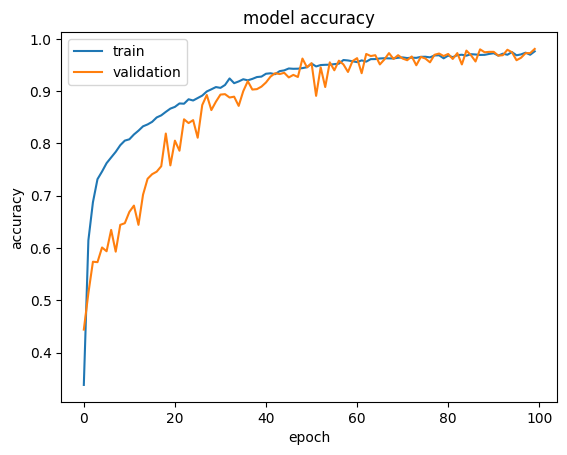

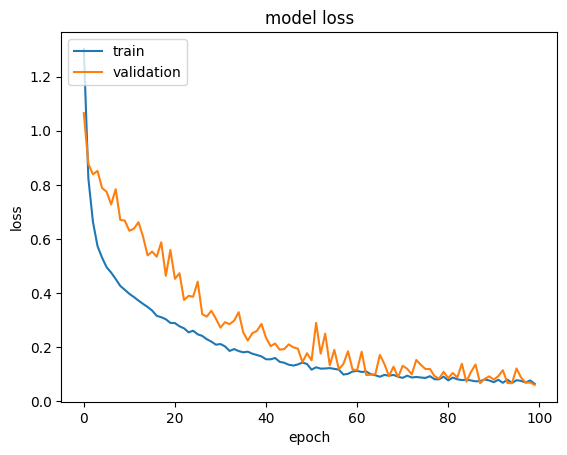

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

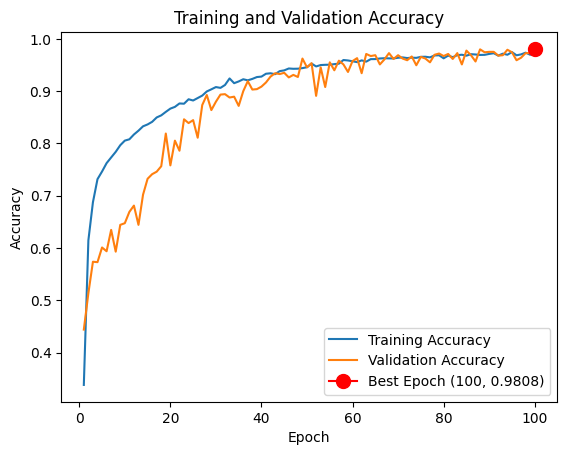

In [13]:
# Extracting the validation accuracy values and finding the epoch with the highest value
val_acc = history.history['val_accuracy']
best_epoch = val_acc.index(max(val_acc)) + 1  # Add 1 to convert index to epoch number

# Plotting the training history
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Highlighting the epoch with the highest validation accuracy
plt.plot(best_epoch, val_acc[best_epoch - 1], marker='o', markersize=10, label=f'Best Epoch ({best_epoch}, {val_acc[best_epoch - 1]:.4f})', color='red')

# Adding plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [14]:
from tensorflow.keras.models import load_model

model.save('best_weights.h5')

In [ ]:
# load model
model = load_model('/kaggle/working/best_weights.h5')

In [15]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

39/39 [==============================] - 4s 98ms/step - loss: 0.0594 - accuracy: 0.9808
Accuracy Test : 0.9807692170143127


In [16]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_set.classes, y_pred)
cr = classification_report(test_set.classes, y_pred, target_names=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])

40/40 [==============================] - 4s 100ms/step


In [17]:
print(cm)
print(cr)

[[175   0   1   3]
 [  0  12   0   0]
 [  1   0 634   5]
 [  4   0  10 434]]
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.98      0.97       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.98      0.99      0.99       640
Very Mild Impairment       0.98      0.97      0.98       448

            accuracy                           0.98      1279
           macro avg       0.98      0.98      0.98      1279
        weighted avg       0.98      0.98      0.98      1279



In [18]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_pred,test_set.classes)))
print('Cohen Kappa Score: {:.2f}'.format(cohen_kappa_score(y_pred,test_set.classes)))
print('Recall: {:.2f}'.format(recall_score(test_set.classes, y_pred, average='micro')))
print('F1-score: {:.2f}'.format(f1_score(test_set.classes, y_pred, average='micro')))
print('Precision: {:.2f}'.format(precision_score(test_set.classes, y_pred, average='macro')))


Accuracy: 0.98

Cohen Kappa Score: 0.97
Recall: 0.98
F1-score: 0.98
Precision: 0.98


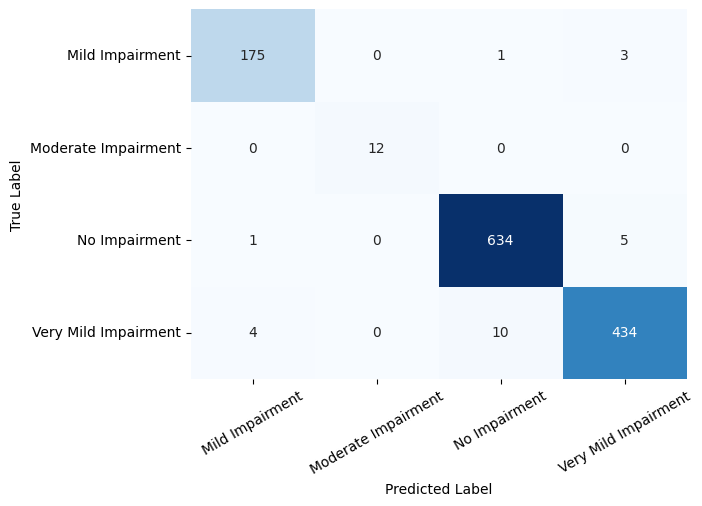

In [19]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

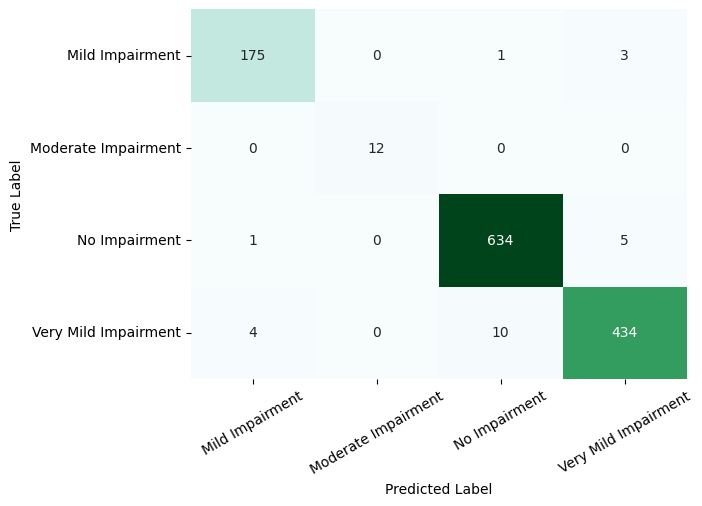

In [28]:
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

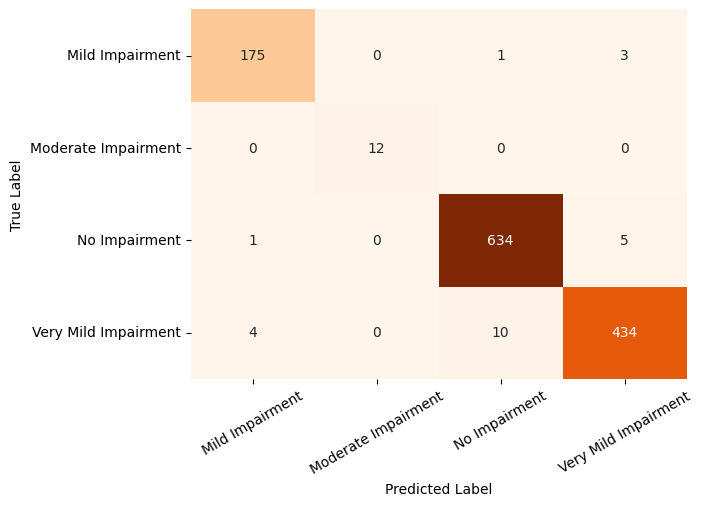

In [29]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

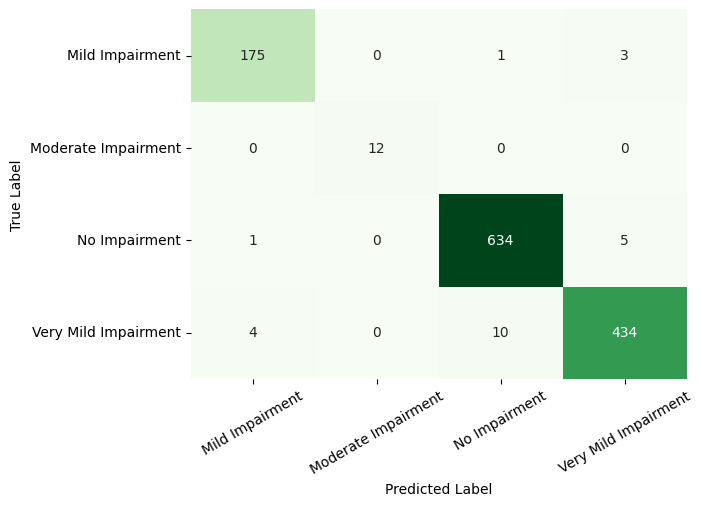

In [30]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], yticklabels=['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'], cbar=False)
plt.xticks(rotation=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()